In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 128)   512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 128)   512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 128)   512         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9917 - acc: 0.5108
Epoch 00001: val_loss improved from inf to 1.63963, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_4_conv_checkpoint/001-1.6396.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.9918 - acc: 0.5108 - val_loss: 1.6396 - val_acc: 0.5656
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0203 - acc: 0.7310
Epoch 00002: val_loss improved from 1.63963 to 1.60884, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_4_conv_checkpoint/002-1.6088.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 1.0202 - acc: 0.7310 - val_loss: 1.6088 - val_acc: 0.6252
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5890 - acc: 0.8375
Epoch 00003: val_loss improved from 1

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0614 - acc: 0.9864
Epoch 00028: val_loss did not improve from 1.45764
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0614 - acc: 0.9864 - val_loss: 2.6424 - val_acc: 0.6655
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9900
Epoch 00029: val_loss did not improve from 1.45764
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0511 - acc: 0.9899 - val_loss: 2.6894 - val_acc: 0.6564
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9789
Epoch 00030: val_loss did not improve from 1.45764
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0975 - acc: 0.9788 - val_loss: 2.5496 - val_acc: 0.6760
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9842
Epoch 00031: val_loss did not improve from 1.45764
36805/36805 [========

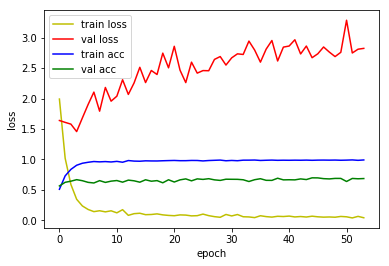

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.6617 - acc: 0.6268
Loss: 1.6617056480449308 Accuracy: 0.6267913

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6073 - acc: 0.5407
Epoch 00001: val_loss improved from inf to 1.45173, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_5_conv_checkpoint/001-1.4517.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.6074 - acc: 0.5407 - val_loss: 1.4517 - val_acc: 0.5637
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9895 - acc: 0.7186
Epoch 00002: val_loss improved from 1.45173 to 1.06259, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_5_conv_checkpoint/002-1.0626.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.9897 - acc: 0.7185 - val_loss: 1.0626 - val_acc: 0.7063
Epoch 3/500
36800/36805 [======================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9860
Epoch 00029: val_loss did not improve from 0.83588
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0557 - acc: 0.9860 - val_loss: 1.2493 - val_acc: 0.7841
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9905
Epoch 00030: val_loss did not improve from 0.83588
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0379 - acc: 0.9904 - val_loss: 1.2360 - val_acc: 0.7838
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0622 - acc: 0.9840
Epoch 00031: val_loss did not improve from 0.83588
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0622 - acc: 0.9840 - val_loss: 0.9948 - val_acc: 0.8176
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9940
Epoch 00032: val_loss did not improve from 0.83588
36805/36805 [========

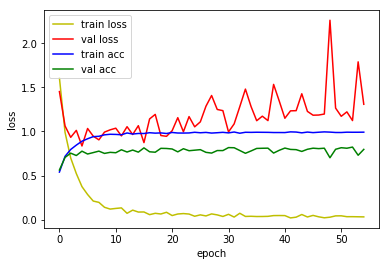

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.9154 - acc: 0.7460
Loss: 0.915381581637223 Accuracy: 0.7460021

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4535 - acc: 0.5694
Epoch 00001: val_loss improved from inf to 1.22151, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_6_conv_checkpoint/001-1.2215.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 1.4535 - acc: 0.5694 - val_loss: 1.2215 - val_acc: 0.6245
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7849 - acc: 0.7744
Epoch 00002: val_loss improved from 1.22151 to 0.82029, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_6_conv_checkpoint/002-0.8203.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.7850 - acc: 0.7744 - val_loss: 0.8203 - val_acc: 0.7650
Epoch 3/500
36800/36805 [=======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9908
Epoch 00027: val_loss did not improve from 0.40617
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0356 - acc: 0.9907 - val_loss: 0.5165 - val_acc: 0.8915
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9866
Epoch 00028: val_loss did not improve from 0.40617
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0501 - acc: 0.9865 - val_loss: 0.5379 - val_acc: 0.8873
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9867
Epoch 00029: val_loss did not improve from 0.40617
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0488 - acc: 0.9866 - val_loss: 0.4415 - val_acc: 0.9050
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9899
Epoch 00030: val_loss did not improve from 0.40617
36805/36805 [=====================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9955
Epoch 00057: val_loss did not improve from 0.40617
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0192 - acc: 0.9955 - val_loss: 0.4585 - val_acc: 0.9101
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9982
Epoch 00058: val_loss did not improve from 0.40617
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0087 - acc: 0.9982 - val_loss: 0.4735 - val_acc: 0.9182
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9913
Epoch 00059: val_loss did not improve from 0.40617
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0324 - acc: 0.9913 - val_loss: 0.4885 - val_acc: 0.9152
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9941
Epoch 00060: val_loss did not improve from 0.40617
36805/36805 [========

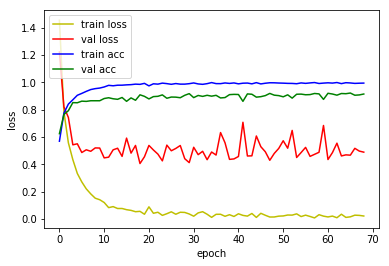

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4748 - acc: 0.8839
Loss: 0.4747863867696324 Accuracy: 0.88390446

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2699 - acc: 0.6202
Epoch 00001: val_loss improved from inf to 1.02218, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_7_conv_checkpoint/001-1.0222.hdf5
36805/36805 [==============================] - 121s 3ms/sample - loss: 1.2698 - acc: 0.6202 - val_loss: 1.0222 - val_acc: 0.6853
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5486 - acc: 0.8389
Epoch 00002: val_loss improved from 1.02218 to 0.42716, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_7_conv_checkpoint/002-0.4272.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.5486 - acc: 0.8389 - val_loss: 0.4272 - val_acc: 0.8721
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9924
Epoch 00026: val_loss did not improve from 0.17371
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0266 - acc: 0.9924 - val_loss: 0.2270 - val_acc: 0.9439
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9974
Epoch 00027: val_loss did not improve from 0.17371
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0134 - acc: 0.9974 - val_loss: 0.2183 - val_acc: 0.9488
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9944
Epoch 00028: val_loss did not improve from 0.17371
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0216 - acc: 0.9943 - val_loss: 0.2041 - val_acc: 0.9490
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9930
Epoch 00029: val_loss did not improve from 0.17371
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9985
Epoch 00055: val_loss did not improve from 0.17297
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0059 - acc: 0.9985 - val_loss: 0.2106 - val_acc: 0.9520
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9959
Epoch 00056: val_loss did not improve from 0.17297
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0146 - acc: 0.9959 - val_loss: 0.1863 - val_acc: 0.9583
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9986
Epoch 00057: val_loss did not improve from 0.17297
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0064 - acc: 0.9986 - val_loss: 0.1998 - val_acc: 0.9553
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9946
Epoch 00058: val_loss did not improve from 0.17297
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9982
Epoch 00085: val_loss did not improve from 0.17297
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0070 - acc: 0.9982 - val_loss: 0.2292 - val_acc: 0.9546
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9990
Epoch 00086: val_loss did not improve from 0.17297
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0039 - acc: 0.9990 - val_loss: 0.2360 - val_acc: 0.9513

1D_CNN_custom_multi_2_concat_ch_128_BN_7_conv Model


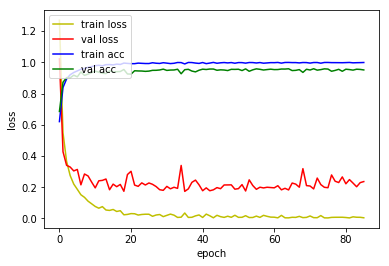

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2477 - acc: 0.9412
Loss: 0.24774486179292388 Accuracy: 0.94122535

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9789 - acc: 0.6998
Epoch 00001: val_loss improved from inf to 0.67501, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_8_conv_checkpoint/001-0.6750.hdf5
36805/36805 [==============================] - 127s 3ms/sample - loss: 0.9789 - acc: 0.6998 - val_loss: 0.6750 - val_acc: 0.8213
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3606 - acc: 0.8920
Epoch 00002: val_loss improved from 0.67501 to 0.39502, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_BN_8_conv_checkpoint/002-0.3950.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.3606 - acc: 0.8920 - val_loss: 0.3950 - val_acc: 0.8824
Epoch 3/500
36800/36805 [====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9982
Epoch 00026: val_loss did not improve from 0.14629
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0093 - acc: 0.9982 - val_loss: 0.2051 - val_acc: 0.9515
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9940
Epoch 00027: val_loss did not improve from 0.14629
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0205 - acc: 0.9940 - val_loss: 0.1837 - val_acc: 0.9541
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9958
Epoch 00028: val_loss did not improve from 0.14629
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0149 - acc: 0.9958 - val_loss: 0.1472 - val_acc: 0.9625
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9970
Epoch 00029: val_loss did not improve from 0.14629
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9995
Epoch 00055: val_loss did not improve from 0.14352
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0028 - acc: 0.9995 - val_loss: 0.1435 - val_acc: 0.9641
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9996
Epoch 00056: val_loss did not improve from 0.14352
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0021 - acc: 0.9996 - val_loss: 0.1530 - val_acc: 0.9667
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9960
Epoch 00057: val_loss did not improve from 0.14352
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0148 - acc: 0.9960 - val_loss: 0.1611 - val_acc: 0.9613
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9995
Epoch 00058: val_loss did not improve from 0.14352
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9994
Epoch 00084: val_loss did not improve from 0.13865
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0021 - acc: 0.9994 - val_loss: 0.1443 - val_acc: 0.9679
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0012 - acc: 0.9998
Epoch 00085: val_loss did not improve from 0.13865
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1565 - val_acc: 0.9660
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9976
Epoch 00086: val_loss did not improve from 0.13865
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0076 - acc: 0.9976 - val_loss: 0.2764 - val_acc: 0.9420
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9989
Epoch 00087: val_loss did not improve from 0.13865
36805/36805 [=====================

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9993
Epoch 00114: val_loss did not improve from 0.13865
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0028 - acc: 0.9993 - val_loss: 0.1704 - val_acc: 0.9646
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9973
Epoch 00115: val_loss did not improve from 0.13865
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0091 - acc: 0.9973 - val_loss: 0.1625 - val_acc: 0.9634
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.2299e-04 - acc: 0.9999
Epoch 00116: val_loss did not improve from 0.13865
36805/36805 [==============================] - 112s 3ms/sample - loss: 8.2321e-04 - acc: 0.9999 - val_loss: 0.1505 - val_acc: 0.9672
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6258e-04 - acc: 1.0000
Epoch 00117: val_loss did not improve from 0.13865
36805

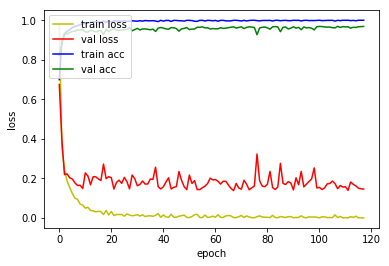

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1867 - acc: 0.9580
Loss: 0.18672584858800353 Accuracy: 0.95804775



In [10]:
base = '1D_CNN_custom_multi_2_concat_ch_128_BN'

for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_ch_128_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_39[0][0]  
________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.9154 - acc: 0.7460
Loss: 0.915381581637223 Accuracy: 0.7460021

1D_CNN_custom_multi_2_concat_ch_128_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_50 (Batc (None, 16000, 128)   512         conv1d_42[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activati

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2477 - acc: 0.9412
Loss: 0.24774486179292388 Accuracy: 0.94122535

1D_CNN_custom_multi_2_concat_ch_128_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_65 (Batc (None, 16000, 128)   512         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activ

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1867 - acc: 0.9580
Loss: 0.18672584858800353 Accuracy: 0.95804775


In [12]:
for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_concat_ch_128_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_39[0][0]  
________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.4743 - acc: 0.7786
Loss: 1.4743238660281568 Accuracy: 0.7786085

1D_CNN_custom_multi_2_concat_ch_128_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_50 (Batc (None, 16000, 128)   512         conv1d_42[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activat

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3139 - acc: 0.9394
Loss: 0.31393852422356233 Accuracy: 0.9393562

1D_CNN_custom_multi_2_concat_ch_128_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_65 (Batc (None, 16000, 128)   512         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activa

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1936 - acc: 0.9593
Loss: 0.1935517892410238 Accuracy: 0.9592939
